# Assignment 1 
### Social Data and Analysis 2026 

## Assignment 1.1: Temporal Overview

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
# Load data 
#recent_data = pd.read_csv('data/recent.csv')
#historical_data = pd.read_csv('data/historical.csv')
focus_data = pd.read_csv('data/focus.csv')

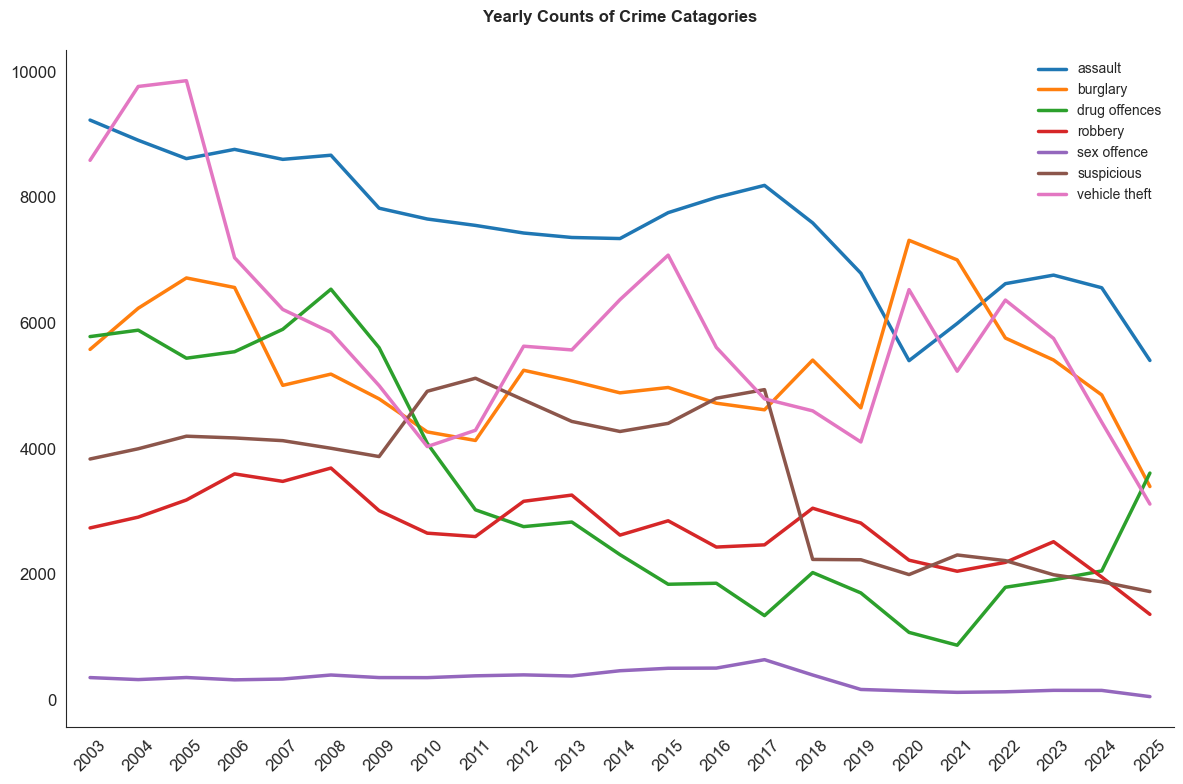

In [ ]:
focus = ['assault', 'vehicle theft', 'drug offences', 'burglary', 'robbery', 'suspicious', 'sex offence']

focus_data['Date'] = pd.to_datetime(focus_data['Date'], format='%Y-%m-%d')
focus_data['year'] = focus_data['Date'].dt.year
focus_data['month'] = focus_data['Date'].dt.month

df_focus = focus_data[focus_data['Category'].isin(focus)]
yearly_counts = df_focus[df_focus['year'] <= 2025].groupby(['year', 'Category']).size().unstack(fill_value=0)

# Set seaborn style
sns.set_style("white")
sns.set_palette("tab10")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12, 8))
for crime in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[crime], label=crime, linewidth=2.5, markersize=8)

plt.title("Yearly Counts of Crime Catagories", fontsize=12, fontweight='bold', pad=20)

plt.xlim(2002.5, 2025.5)
plt.xticks(yearly_counts.index, rotation=45)
plt.legend(frameon=False, loc='best', fontsize=10)
sns.despine()
plt.tight_layout()

plt.show()


### Key trends in focus areas:

1) **Drop in number of assult during COVID:**
There is a noticeable drop in recorded assault offences around 2020. Around this time, COVID restrictions were enforced, limiting nightlife and public gatherings and reducing face-to-face interactions. This resulted in far fewer opportunities for interpersonal violence, which is clearly reflected in the data.

2) **Surge in burglaryes and vehicle theft during covid:**
During the pandemic, the data shows an opposite, but just as noticeable, trend — a surge in recorded vehicle thefts and burglaries. This trend can also be explained by the social impacts of COVID restrictions. Empty buildings, reduced street activity, and longer periods of parked vehicles created more opportunities for property crime. Additionally, COVID was a time of increased economic stress, which likely also contributed to this rise. 

3) **General drop in drug offences, then surge again around 21-22**
Drug offenses declined steadily for much of the timeline until around the pandemic period in 2021. This long-term decrease was driven in part by reduced enforcement and a shift toward diversion and treatment rather than arrest for low-level drug possession. By 2024, however, the number of recorded drug offenses rose to above pre-pandemic levels. This reversal reflects a change in policy and enforcement focus: in response to public pressure tied to highly visible drug markets, overdose deaths, and street disorder, San Francisco increased enforcement of drug-related offenses. Police began making more arrests, particularly for dealing and public drug use, as part of an effort to address open-air drug activity rather than relying primarily on treatment and diversion. In 2024, the mayor signed legislation allowing police to arrest drug users and transport them to a treatment facility, which emphasises the city’s change in course.

4) **General decline in robberies:**
Robbery shows a general long-term downward trend. The shift toward cashless payments, increased surveillance, and widespread smartphone tracking have reduced both the payoff and success rate of robberies. Even during periods of social disruption, robbery continues to decline.





## Assignment 1.2: Crime Profiles by District

In [4]:
focus_data.head()

,PdId,Date,Time,DayOfWeek,IncidntNum,Incident Code,Category,Resolution,PdDistrict,data_loaded_at,year,month
0,152278216710,2025-10-31,17:55,Friday,250613625,16710,drug offences,Cite or Arrest Adult,MISSION,2025/11/05 09:59:28 AM,2025,10
1,148998204134,2025-06-13,12:41,Friday,250329888,4134,assault,Open or Active,INGLESIDE,2025/06/15 09:53:25 AM,2025,6
2,153811216100,2026-01-08,13:44,Thursday,260013827,16100,drug offences,Cite or Arrest Adult,TENDERLOIN,2026/01/10 09:57:31 AM,2026,1
3,148983205043,2025-06-11,08:00,Wednesday,250327597,5043,burglary,Open or Active,NORTHERN,2025/06/14 09:53:06 AM,2025,6
4,148969503014,2025-06-12,00:09,Thursday,250326840,3014,robbery,Cite or Arrest Adult,MISSION,2025/06/14 09:53:06 AM,2025,6


In [7]:
# Count crimes per district per category
district_counts = df_focus.groupby(['PdDistrict', 'Category']).size().unstack(fill_value=0)
district_counts

Category,assault,burglary,drug offences,robbery,sex offence,suspicious,vehicle theft
PdDistrict,,,,,,,
BAYVIEW,19543,11960,5448,6863,526,9610,19879
CENTRAL,17819,15269,2722,6859,761,8372,10596
INGLESIDE,15979,11284,2786,7043,634,7673,21812
MISSION,26651,13719,12597,10025,1331,10274,18319
NORTHERN,19604,19545,6225,7477,823,8650,15324
OUT OF SF,205,64,138,69,27,249,547
PARK,7092,9293,3270,2195,373,4207,9155
RICHMOND,6427,9004,1170,2185,338,5478,9625
SOUTHERN,28519,15917,13239,9721,1463,12851,12819


In [10]:
# Normalize
district_profile = district_counts.div(district_counts.sum(axis=1), axis=0)


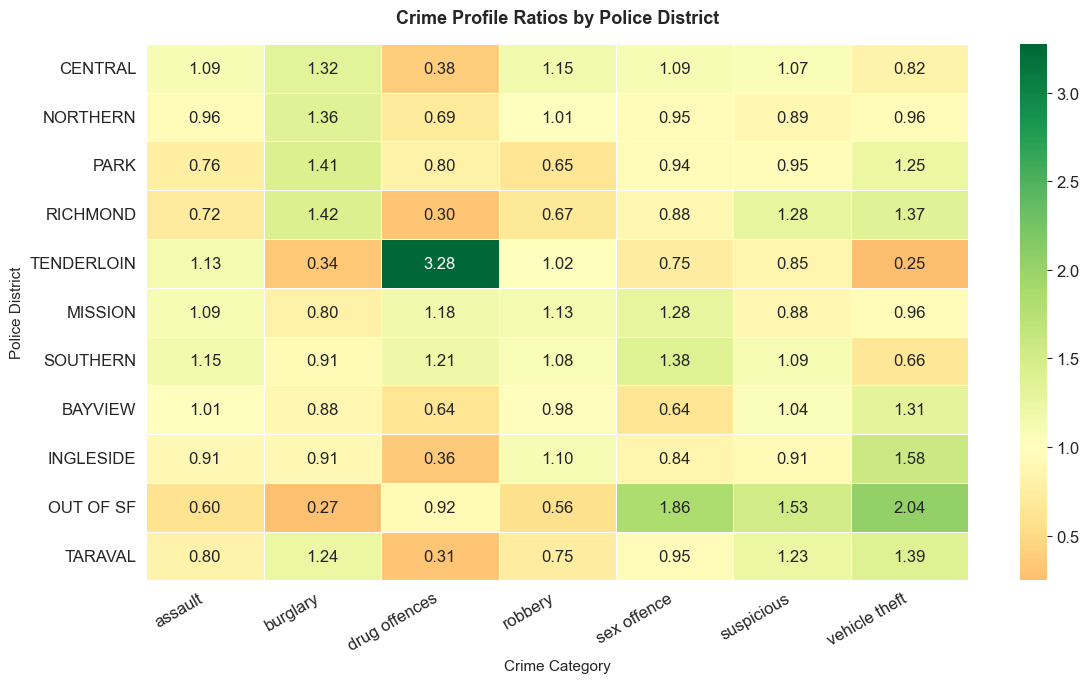

In [13]:
# Raw counts per district per crime
district_counts = df_focus.groupby(['PdDistrict', 'Category']).size().unstack(fill_value=0)

# Row-normalize to get P(crime | district)
district_profile = district_counts.div(district_counts.sum(axis=1), axis=0)

# City-wide probability for each crime P(crime | city)
city_wide = df_focus['Category'].value_counts(normalize=True)

# Divide to get the ratio — values > 1 mean over-represented
district_ratio = district_profile.div(city_wide, axis=1)

# Sort districts by dominant crime for readability
district_ratio_sorted = district_ratio.loc[district_ratio.idxmax(axis=1).sort_values().index]

plt.figure(figsize=(12, 7))
sns.heatmap(
    district_ratio_sorted,
    cmap='RdYlGn',        # green = over-represented, red = under-represented
    center=1,             # 1 is the neutral point
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    #cbar_kws={'label': 'Ratio to city-wide average (1.0 = average)'}
)
plt.title('Crime Profile Ratios by Police District', #\n(values > 1 = over-represented vs. city average)', 
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Crime Category', fontsize=11)
plt.ylabel('Police District', fontsize=11)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### Crime Profile Ratios by Police District

The heatmap shows the ratio $r(\text{crime}, \text{district}) = \frac{P(\text{crime} \mid \text{district})}{P(\text{crime})}$ for each combination of police district and crime category. A value of 1.0 means the crime occurs at exactly the city-wide average rate in that district; values above 1 indicate over-representation and values below 1 indicate under-representation.

**Tenderloin** is the most striking district in the entire heatmap. It has a drug offences ratio of **3.28** — meaning drug crime is more than three times as common there compared to the city average. At the same time, vehicle theft is heavily under-represented (0.25), which makes sense given that the Tenderloin is a dense, pedestrian-heavy neighborhood with fewer privately parked vehicles. The Tenderloin has long been the center of San Francisco's open-air drug market, and this data confirms that pattern clearly.

**Out of SF** stands out for vehicle theft (2.04) and sex offences (1.86), while having very low burglary (0.27) and assault (0.60). The high vehicle theft ratio likely reflects that incidents near highways or city boundaries — where cars are more vulnerable and less monitored — are logged under this category.

**Richmond** and **Taraval** both show elevated burglary ratios (1.42 and 1.24 respectively) and low drug offences (0.30 and 0.31). These are quieter, residential western neighborhoods with more houses and shops to burglarize, but far less street-level drug activity than central districts.

**Central** and **Northern** districts show relatively balanced profiles close to 1.0 across most categories, suggesting they reflect the city-wide average reasonably well — unsurprising given their central location covering mixed-use tourist and commercial areas.

Overall, the heatmap reveals that crime in San Francisco is far from uniformly distributed. Each district has a distinct signature shaped by its geography, land use, and socioeconomic conditions, with the Tenderloin's drug dominance being the most pronounced example.


## Assignment 1.3: Visualizing Distributions

### Part A — Jitter Plot
To investigate how incident times are recorded in the dataset, we selected assault as our focus crime and filtered incidents occurring between 13:00–14:00 over a three-month period (January–March 2015). 

In [14]:
# Filter: assault, one hour window, a few months
mask = (
    (focus_data['Category'] == 'assault') &
    (focus_data['Date'] >= '2015-01-01') &
    (focus_data['Date'] <= '2015-03-31')
)
df_jitter = focus_data[mask].copy()

In [15]:
# Extract hour and minute
df_jitter['hour'] = pd.to_datetime(df_jitter['Time'], format='%H:%M').dt.hour
df_jitter['minute'] = pd.to_datetime(df_jitter['Time'], format='%H:%M').dt.minute

# Filter to the 13:00-14:00 window
df_jitter = df_jitter[df_jitter['hour'] == 13]

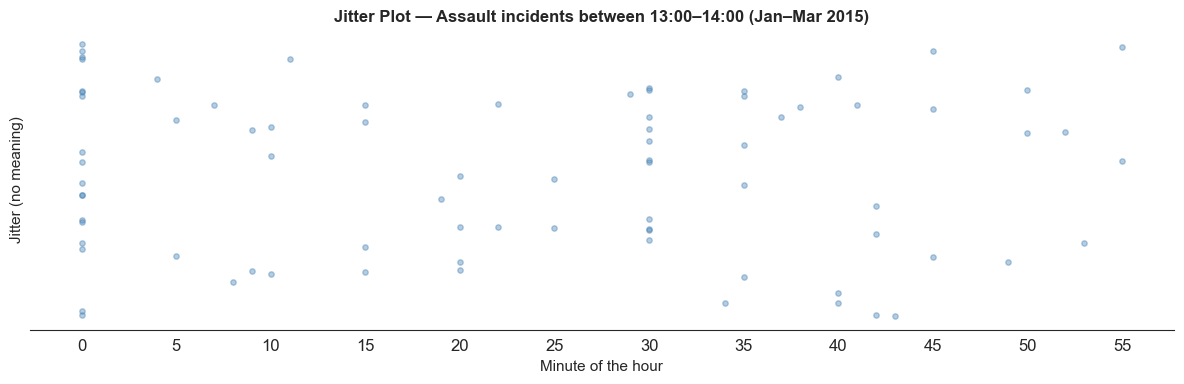

In [16]:
# Create jitter plot
plt.figure(figsize=(12, 4))
plt.scatter(
    df_jitter['minute'],
    np.random.uniform(-1, 1, size=len(df_jitter)),  # vertical jitter
    alpha=0.4,
    s=15,
    color='steelblue'
)
plt.xlabel('Minute of the hour', fontsize=11)
plt.ylabel('Jitter (no meaning)', fontsize=11)
plt.title('Jitter Plot — Assault incidents between 13:00–14:00 (Jan–Mar 2015)', fontsize=12, fontweight='bold')
plt.xticks(range(0, 60, 5))
plt.yticks([])
sns.despine(left=True)
plt.tight_layout()
plt.show()

Each dot represents one recorded incident, with the x-axis showing the minute within the hour and vertical jitter added purely to separate overlapping points.
The most immediately striking pattern is the large cluster of incidents recorded at minute 0 (i.e. exactly on the hour). This spike is far larger than any other minute, suggesting that officers frequently round the time of an incident to the nearest full hour when filing their report. A smaller but still noticeable cluster appears at minute 30, consistent with rounding to the half hour as well.
Outside of these two peaks, incidents are scattered relatively thinly and somewhat randomly across the other minutes, with no other strong clustering visible.
This tells us something important about the precision of the data: recorded times should not be treated as exact measurements. A significant fraction of incidents have their time rounded to the nearest hour or half hour, meaning any fine-grained time analysis (e.g. "crimes peak at 13:07") would be misleading. For broad hourly analysis this is not a major problem, but it is a limitation worth keeping in mind.

### Part B — Probability plot:

In [ ]:
# Pick two crimes to compare
crimes_qq = ['assault', 'vehicle theft']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, crime in zip(axes, crimes_qq):
    subset = focus_data[focus_data['Category'] == crime]['Latitude'].dropna()
    stats.probplot(subset, dist='norm', plot=ax)
    ax.set_title(f'QQ Plot — {crime.title()} (Latitude)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Theoretical quantiles')
    ax.set_ylabel('Observed quantiles')

plt.tight_layout()
plt.show()

In [19]:
focus_data.columns.tolist()


['PdId',
 'Date',
 'Time',
 'DayOfWeek',
 'IncidntNum',
 'Incident Code',
 'Category',
 'Resolution',
 'PdDistrict',
 'data_loaded_at',
 'year',
 'month']

We need to get the X,Y from the original data!

In [20]:
focus_data["PdDistrict"].value_counts().head(15)

PdDistrict
SOUTHERN      113003
MISSION       108436
NORTHERN       92737
BAYVIEW        87659
INGLESIDE      79884
TENDERLOIN     77074
CENTRAL        75826
TARAVAL        61718
PARK           42405
RICHMOND       41876
OUT OF SF       1378
Name: count, dtype: int64